In [ ]:
## Dataset Access,this notebook uses a Kaggle dataset.Users must upload their `kaggle.json` API key file to download the dataset automatically.
from google.colab import files
files.upload()   # ارفع kaggle.json من حسابك

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# تحميل dataset من Kaggle
!kaggle datasets download -d samayashar/fraud-detection-transactions-dataset
!unzip -o fraud-detection-transactions-dataset.zip -d ./data

# التحقق من الملفات
!ls ./data


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv("./data/synthetic_fraud_dataset.csv")

# حذف عمود Location
df = df.drop('Location', axis=1, errors='ignore')

print("Dataset shape:", df.shape)
display(df.head())
df.info()


Dataset shape: (50000, 20)


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Merchant_Category,IP_Address_Flag,Previous_Fraudulent_Activity,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Travel,0,0,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,Clothing,0,0,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Restaurants,0,0,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,Clothing,0,0,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Electronics,0,1,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                50000 non-null  object 
 1   User_ID                       50000 non-null  object 
 2   Transaction_Amount            50000 non-null  float64
 3   Transaction_Type              50000 non-null  object 
 4   Timestamp                     50000 non-null  object 
 5   Account_Balance               50000 non-null  float64
 6   Device_Type                   50000 non-null  object 
 7   Merchant_Category             50000 non-null  object 
 8   IP_Address_Flag               50000 non-null  int64  
 9   Previous_Fraudulent_Activity  50000 non-null  int64  
 10  Daily_Transaction_Count       50000 non-null  int64  
 11  Avg_Transaction_Amount_7d     50000 non-null  float64
 12  Failed_Transaction_Count_7d   50000 non-null  int64  
 13  C

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# العمود الهدف
target_col = 'IP_Address_Flag'
y = df[target_col]

# Features (كل الأعمدة الأخرى ما عدا Location وTarget)
X = df.drop([target_col, 'Location'], axis=1, errors='ignore')

# تحويل الأعمدة النصية إلى أرقام
le_dict = {}
for col in X.select_dtypes(include='object').columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    le_dict[col] = le

# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (40000, 19)
Test set shape: (10000, 19)


In [ ]:
import xgboost as xgb

# حساب وزن الاحتيال للتعامل مع الفئة غير المتوازنة
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)
print("Scale_pos_weight:", scale_pos_weight)

# تهيئة النموذج
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)
print("Model training completed!")


Scale_pos_weight: 18.9203187250996


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [10:06:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Model training completed!


Confusion Matrix:
[[8292 1206]
 [ 429   73]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      9498
           1       0.06      0.15      0.08       502

    accuracy                           0.84     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.91      0.84      0.87     10000

ROC-AUC Score: 0.4956531003801178


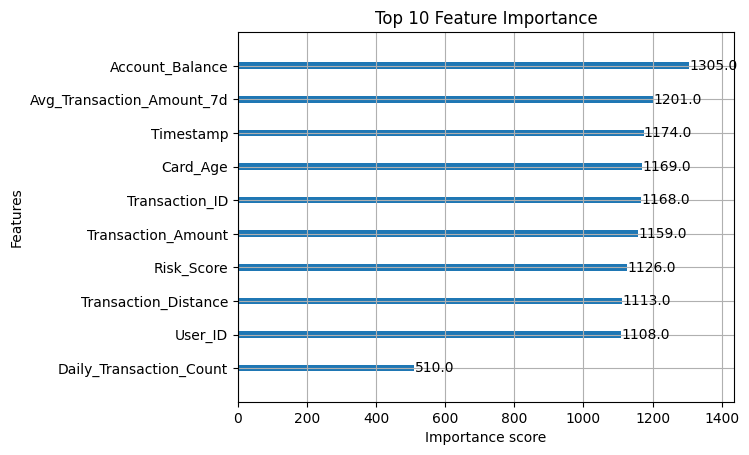

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)

# Feature Importance
xgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importance")
plt.show()


In [ ]:
import gradio as gr
import pandas as pd

def predict_fraud(*inputs):
    input_df = pd.DataFrame([inputs], columns=X.columns)
    # تحويل القيم النصية إلى أرقام
    for col in le_dict:
        input_df[col] = le_dict[col].transform(input_df[col])
    pred = model.predict(input_df)[0]
    prob = model.predict_proba(input_df)[0][1]
    return "احتيال" if pred == 1 else "عادي", prob

inputs = []
for col in X.columns:
    if X[col].dtype == 'object':
        inputs.append(gr.Textbox(label=col))
    else:
        inputs.append(gr.Number(label=col))

iface = gr.Interface(fn=predict_fraud,
                     inputs=inputs,
                     outputs=[gr.Textbox(label="Prediction"), gr.Number(label="Probability")])

iface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9c225161fa0562c0ef.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
